In [21]:
import wrds
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
db=wrds.Connection(wrds_username='hlanfran')


Loading library list...
Done


In [3]:
data_netflix=db.raw_sql("select date,ret from crsp.dsf where permno in (89393) and date >= '2011-01-01' and date <= '2021-12-31'")

data_rf=db.raw_sql("select caldt, tdyld from crsp.tfz_dly_rf2 where kytreasnox = 2000061 and caldt >= '2011-01-01' and caldt <= '2021-12-31'")

data_market = db.raw_sql("select  date,vwretd from crsp.dsi where date >= '2011-01-01' and date <= '2021-12-31'")

In [4]:
data_rf = data_rf.rename(columns={"caldt":"date"})
data = data_netflix.merge(data_rf, on = "date")
data = data.merge(data_market, on = "date")

In [5]:
data["excess_return_netflix"] = data.ret - data.tdyld
data["excess_return_market"] = data_market.vwretd - data_rf.tdyld

In [42]:
#(b)
rolling_time=126

var = data['excess_return_market'].rolling(window=rolling_time).var()
cov = data['excess_return_netflix'].rolling(window=rolling_time).cov(data['excess_return_market'])

beta = cov/var

beta.plot(title='Rolling beta')

ValueError: window must be an integer 0 or greater

In [23]:
#(c)
constant_rf = data_rf.mean().values
mean_netflix_returns = data['excess_return_netflix'].mean()
mean_market_returns = data['excess_return_market'].mean()

mx_cov = np.cov(data['excess_return_netflix'], data['excess_return_market'])
constant_beta= mx_cov[1,0]
netflix_var_mean = mx_cov[0,0]
market_var_mean = mx_cov[1,1]

#calculate risk Var[R_i] = beta**2*Var(R_m) + Var[e_i]
netflix_systematic_risk = constant_beta**2*market_var_mean 
netflix_idiosyncratic_risk = netflix_var_mean - netflix_systematic_risk

#generate data
# mean_mean_market + RV where RV ~ N(0,sqrt(var_market))
generated_market_data = np.random.normal(0,np.sqrt(market_var_mean),len(data['excess_return_market'])) + mean_market_returns

# R_i - R_0 = beta_i * (R_m - R_0) + e_i if we assume that netflix is on the SCL so alpha = 0 and e_i ~ N(0,sqrt(netflix_idiosyncratic_risk))
generated_netflix_data = np.random.normal(0,np.sqrt(netflix_idiosyncratic_risk),len(data['excess_return_netflix'])) + (mean_netflix_returns-constant_rf)*constant_beta

generated_data = pd.DataFrame({"Netflix_generated":generated_netflix_data,"Market_generated_data":generated_market_data})


C:\Users\hugol\AppData\Local\Temp\ipykernel_10140\686979683.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  constant_rf = data_rf.mean().values


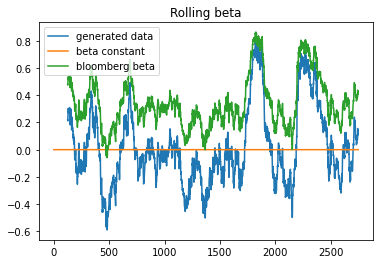

In [33]:
#(d)

len_win=126

#plot generated data
var = generated_data['Market_generated_data'].rolling(window=rolling_time).var()
cov = generated_data['Netflix_generated'].rolling(window=rolling_time).cov(generated_data['Market_generated_data'])

beta = cov/var
beta.plot(label="generated data",title='Rolling beta')

#plot constant beta
beta_plot = pd.Series(constant_beta,generated_data.index)
beta_plot.plot(label="beta constant")

#plot adjusted beta
beta_bloomberg = pd.Series(1/3 + 2/3*beta,generated_data.index)
beta_bloomberg.plot(label="bloomberg beta")

plt.legend()